In [1]:
project_name = "Imc-01"
basefile = f"/kaggle/working/{project_name}"

In [2]:
import os
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from skimage.metrics import structural_similarity as ssim

In [4]:
!pip install torchsummary --quiet
!!pip install lpips --quiet
import torch
import lpips
from torch import nn, optim
import torchvision.transforms as tt
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
paths = glob.glob("/kaggle/input/coco-01-40k/test2017/*.jpg")
len(paths)

40670

In [9]:
def get_img_paths(fpath,max_val,val_ratio):
  paths = np.random.choice(glob.glob(fpath),max_val,replace=False)
  val_paths = paths[:int(max_val*val_ratio)]
  train_paths = paths[int(max_val*val_ratio):]
  return train_paths,val_paths

In [18]:
train_paths,val_paths = get_img_paths("/kaggle/input/coco-01-40k/test2017/*.jpg",21500,0.05)
# train_paths,val_paths = get_img_paths("/kaggle/input/coco-01-40k/test2017/*.jpg",100,0.1)

In [19]:
len(train_paths), len(val_paths)

(20425, 1075)

In [20]:
def denorm(L,ab,stats=(0.5,0.5)):
  image = torch.cat((L,ab),0)
  image = image*stats[1]+stats[0]
  return image

In [21]:
class ColorizationDataset(Dataset):
  def __init__(self, paths, split, size):
    self.paths = paths
    self.transform = tt.Compose([
        tt.Resize((size,size),Image.BICUBIC),
        tt.RandomHorizontalFlip()
    ]) if split=="train" else tt.Resize((size,size),Image.BICUBIC)
    self.normalize = tt.Compose([tt.ToTensor(),tt.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
    self.size = size

  def __getitem__(self, idx):
    img = Image.open(self.paths[idx]).convert("RGB")
    img = np.array(self.transform(img))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    img = self.normalize(img)
    L = img[[0], ...]
    ab = img[[1,2], ...]
    return L, ab

  def __len__(self):
    return len(self.paths)

In [22]:
SIZE = 256
train_ds = ColorizationDataset(paths=train_paths, split='train',size = SIZE)
val_ds = ColorizationDataset(paths=val_paths, split='val',size = SIZE)

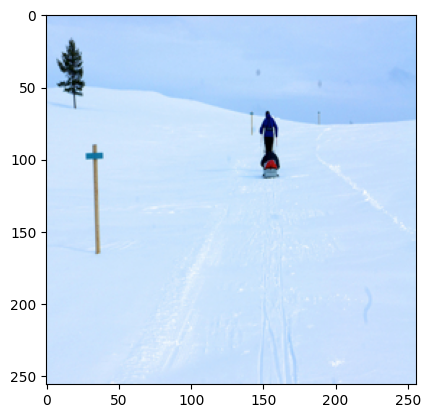

In [23]:
img = (denorm(*train_ds[9]).permute(1,2,0)*255).numpy().astype(np.uint8)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_LAB2RGB))

In [24]:
train_dl = DataLoader(train_ds, batch_size=16,pin_memory=True,shuffle=True)
val_dl = DataLoader(val_ds, batch_size=16,pin_memory=True,shuffle=False)

In [25]:
data = next(iter(train_dl))
Ls, abs = data
print(Ls.shape, abs.shape)
print(len(train_dl),len(val_dl))

torch.Size([16, 1, 256, 256]) torch.Size([16, 2, 256, 256])
1277 68


In [26]:
class UnetBlock(nn.Module):
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False,
                 innermost=False, outermost=False):
        super().__init__()
        self.outermost = outermost
        if input_c is None: input_c = nf
        downconv = nn.Conv2d(input_c, ni, kernel_size=4,
                             stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(nf)

        if outermost:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(ni, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout: up += [nn.Dropout(0.5)]
            model = down + [submodule] + up
        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)

class Unet(nn.Module):
    def __init__(self, input_c=1, output_c=2, n_down=8, num_filters=64):
        super().__init__()
        unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True)
        for _ in range(n_down - 5):
            unet_block = UnetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=True)
        out_filters = num_filters * 8
        for _ in range(3):
            unet_block = UnetBlock(out_filters // 2, out_filters, submodule=unet_block)
            out_filters //= 2
        self.model = UnetBlock(output_c, out_filters, input_c=input_c, submodule=unet_block, outermost=True)

    def forward(self, x):
        return self.model(x)

In [27]:
summary(Unet().to(device),(1,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,024
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,072
       BatchNorm2d-4          [-1, 128, 64, 64]             256
         LeakyReLU-5          [-1, 128, 64, 64]               0
            Conv2d-6          [-1, 256, 32, 32]         524,288
       BatchNorm2d-7          [-1, 256, 32, 32]             512
         LeakyReLU-8          [-1, 256, 32, 32]               0
            Conv2d-9          [-1, 512, 16, 16]       2,097,152
      BatchNorm2d-10          [-1, 512, 16, 16]           1,024
        LeakyReLU-11          [-1, 512, 16, 16]               0
           Conv2d-12            [-1, 512, 8, 8]       4,194,304
      BatchNorm2d-13            [-1, 512, 8, 8]           1,024
        LeakyReLU-14            [-1, 51

In [28]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2)
                          for i in range(n_down)] # the 'if' statement is taking care of not using
                                                  # stride of 2 for the last block in this loop
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)] # Make sure to not use normalization or
                                                                                             # activation for the last layer of the model
        self.model = nn.Sequential(*model)

    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True): # when needing to make some repeatitive blocks of layers,
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]          # it's always helpful to make a separate method for that purpose
        if norm: layers += [nn.BatchNorm2d(nf)]5
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [29]:
summary(PatchDiscriminator(3).to(device),(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,072
       BatchNorm2d-4          [-1, 128, 64, 64]             256
         LeakyReLU-5          [-1, 128, 64, 64]               0
            Conv2d-6          [-1, 256, 32, 32]         524,288
       BatchNorm2d-7          [-1, 256, 32, 32]             512
         LeakyReLU-8          [-1, 256, 32, 32]               0
            Conv2d-9          [-1, 512, 31, 31]       2,097,152
      BatchNorm2d-10          [-1, 512, 31, 31]           1,024
        LeakyReLU-11          [-1, 512, 31, 31]               0
           Conv2d-12            [-1, 1, 30, 30]           8,193
Total params: 2,765,633
Trainable params: 2,765,633
Non-trainable params: 0
---------------------------

In [30]:
class GANLoss(nn.Module):
  def __init__(self,loss=nn.BCEWithLogitsLoss(), real_label=1.0, fake_label=0.0):
    super(GANLoss,self).__init__()
    self.register_buffer('real_label',torch.tensor(real_label))
    self.register_buffer('fake_label',torch.tensor(fake_label))
    self.loss = loss

  def __call__(self,preds,is_real):
    labels = self.real_label.expand_as(preds) if is_real else self.fake_label.expand_as(preds)
    return self.loss(preds,labels)

In [31]:
class AverageMeter:
  def __init__(self):
    self.reset()
    self.records = []

  def reset(self):
    self.count, self.avg, self.sum = [0.]*3

  def snapshot(self):
    if self.count>0 :self.records.append(self.avg)

  def snap_and_reset(self):
    self.snapshot()
    self.reset()

  def update(self,val,count=1):
    self.count += count
    self.sum += count*val
    self.avg = self.sum/self.count

class History:
  def __init__(self,metrics):
    self.metrics = {metric_name: AverageMeter() for metric_name in metrics}
    self.epochs = []

  def update(self, metric_val_pairs:dict,count=1):
    for metric_name, val in metric_val_pairs.items():
      if metric_name in self.metrics:
        self.metrics[metric_name].update(val,count)
      else:
        raise KeyError(f"Metric '{metric_name}' not found in history.")

  def update_all(self, values, count=1):
    if len(values) != len(self.metrics):
      raise ValueError("Mismatch between number of values and metrics.")
    for metric,val in zip(self.metrics.values(),values):
      metric.update(val,count)

  def add_epoch(self,epoch):
    self.epochs.append(epoch)

  def message(self,prefix=""):
    joiner = " "
    text = f"{prefix} "
    for i,(metric_name,metric) in enumerate(self.metrics.items()):
      text += f"{joiner}{metric_name}: {metric.avg:.4f} "
      joiner = '\n' if i%3==0 else ','
    return text.strip()

  def reset_all(self):
    for metric in self.metrics.values():
      metric.reset()

  def snap_and_reset_all(self):
    for metric in self.metrics.values():
      metric.snap_and_reset()

  def __len__(self):
    return len(self.metrics)

  def keys(self):
    return ["epochs"]+self.metrics.keys()

  def values(self):
    return [self.epochs] + [value.records for value in self.metrics.values()]

  def __setitem__(self, key, value):
    if key in self.metrics:
      self.metrics[key].records = value
    elif key=="epochs":
      self.epochs = value
    else:
      raise KeyError(f"Metric '{key}' not found in history.")

  def __getitem__(self, key):
    if key in self.metrics:
      return self.metrics[key].records
    elif key=="epochs":
      return self.epochs
    else:
      raise KeyError(f"Metric '{key}' not found in history.")



In [32]:
def init_weights(net, init='norm', gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')

            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)
    net.apply(init_func)
    print(f"model initialized with {init} initialization")
    return net

In [33]:
def inverse_transform(L, ab):
  Lab = (torch.cat((L,ab),1)*0.5+0.5)*255.
  Lab = Lab.permute(0, 2, 3, 1).detach().cpu().numpy().astype(np.uint8)
  rgb_imgs = []
  for img in Lab:
    img_rgb = cv2.cvtColor(img,cv2.COLOR_LAB2RGB)
    rgb_imgs.append(img_rgb)
  return np.stack(rgb_imgs, axis=0)

def save_samples(path, L, real_ab, fake_ab, show=False, nmax=4, title="Results"):
  nmax = min(nmax, L.size(0))
  real_images = inverse_transform(L, real_ab)
  fake_images = inverse_transform(L, fake_ab)
  fig, axes = plt.subplots(3, nmax, figsize=(15, 8))
  fig.suptitle(title, fontsize=16)
  for i in range(nmax):
    axes[0, i].imshow(L[i][0].cpu(), cmap='gray')
    axes[0, i].axis("off")
    if i == 0:
      axes[0, i].set_title("Input (L)")
    axes[1, i].imshow(fake_images[i])
    axes[1, i].axis("off")
    if i == 0:
      axes[1, i].set_title("Generated (Fake)")
    axes[2, i].imshow(real_images[i])
    axes[2, i].axis("off")
    if i == 0:
      axes[2, i].set_title("Real (AB)")
  fig.savefig(path, bbox_inches='tight')
  if show:
      plt.show()
  plt.close(fig)

In [34]:
from torchvision.models import inception_v3
from scipy import linalg
from torchvision import transforms

In [35]:
inception_model = inception_v3(pretrained=True, transform_input=False).to(device)
lpips_model = lpips.LPIPS(net='vgg')

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 89.0MB/s] 
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated s

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 198MB/s]  


Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


/opt/conda/lib/python3.10/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_location='cpu'), st

In [36]:
def get_inception_features(images, device=device, inception_model = inception_model ):
    # Load InceptionV3 model
    inception_model.eval()
    
    # Resize and normalize images
    preprocess = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    with torch.no_grad():
        # Apply transformations to each image and convert to batch
        processed_images = torch.stack([preprocess(img).to(device) for img in images])
        # Extract features from pool3 layer (2048-dimensional features)
        features = inception_model.forward(processed_images).detach().cpu().numpy()
        
    return features

# Function to calculate FID score
def calculate_fid(real_features, generated_features):
    # Calculate mean and covariance for both sets of features
    mu_real = np.mean(real_features, axis=0)
    sigma_real = np.cov(real_features, rowvar=False)
    
    mu_gen = np.mean(generated_features, axis=0)
    sigma_gen = np.cov(generated_features, rowvar=False)
    
    # Calculate the squared difference between means
    mean_diff = np.sum((mu_real - mu_gen) ** 2)
    
    # Calculate sqrt of product of covariance matrices
    covmean, _ = linalg.sqrtm(sigma_real.dot(sigma_gen), disp=False)
    
    # Handle numerical errors in the covariance matrix multiplication
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    # Calculate FID score
    fid_score = mean_diff + np.trace(sigma_real + sigma_gen - 2 * covmean)
    
    return fid_score

In [37]:
def get_lpips(real_imgs, fake_imgs, device= device):
    
    real_imgs = ((torch.from_numpy(real_imgs).permute(0, 3, 1, 2).to(device).float() / 255.0)*2)-1
    fake_imgs = ((torch.from_numpy(fake_imgs).permute(0, 3, 1, 2).to(device).float() / 255.0)*2)-1
    lpips_model.to(device)
    
    lpips_scores = lpips_model(real_imgs, fake_imgs)
    lpips_score = lpips_scores.mean()
    
    return lpips_score.item()

def get_fid(real_imgs, fake_imgs, device):
    real_images = [transforms.ToPILImage()(img) for img in real_imgs]
    generated_images = [transforms.ToPILImage()(img) for img in fake_imgs]

    real_features = get_inception_features(real_images, device)
    generated_features = get_inception_features(generated_images, device)

    fid = calculate_fid(real_features, generated_features)

    return fid

In [38]:
def get_metrics(L, real_ab, fake_ab, device=device, val=False):
    # Concatenate L channel with real/fake ab channels and convert to [0, 255] range
    real_imgs = inverse_transform(L, real_ab)
    fake_imgs = inverse_transform(L, fake_ab)
    
    lpips_score = get_lpips(real_imgs, fake_imgs, device)
    fid_score = get_fid(real_imgs, fake_imgs, device)
    return lpips_score, fid_score

In [39]:
from tqdm import tqdm
from torch.amp import  GradScaler, autocast
import torch.nn.functional as F

In [40]:
for i in tqdm(range(10000)):
    pass

100%|██████████| 10000/10000 [00:00<00:00, 1566500.09it/s]


In [57]:
class GANTrainer:
    def __init__(self, generator, discriminator,
                 opt_g, opt_d,
                 batch_size, device, save_path,
                 gan_loss,l1_loss, val_loss,
                 l1_lambda,
                 checkpoint_save_path,
                 checkpoint_save_frequency
                 ):
        self.history = None
        self.gen = generator.to(device)
        self.disc = discriminator.to(device)
        self.opt_g = opt_g
        self.opt_d = opt_d
        self.device = device
        self.batch_size = batch_size
        self.scaler_g = GradScaler(device=device)
        self.scaler_d = GradScaler(device=device)
        self.gan_loss= gan_loss
        self.l1_loss = l1_loss
        self.val_loss = val_loss
        self.l1_lambda = l1_lambda
        self.current_epoch = 0
        self.checkpoint_save_frequency = checkpoint_save_frequency
        self.save_path = save_path
        self.checkpoint_save_path = checkpoint_save_path
        os.makedirs(save_path, exist_ok=True)
        os.makedirs(save_path+"/random", exist_ok=True)
        os.makedirs(checkpoint_save_path, exist_ok=True)

    def setup_input(self,L,ab):
      return L.to(self.device),ab.to(self.device)

    def compile(self,init_method = "norm"):
        self.history = History(("loss_d","loss_g","loss_l1","val_loss", "val_lpips_score", "val_fid_score"))
        self.gen = init_weights(self.gen,init_method)
        self.disc = init_weights(self.disc,init_method)

    @staticmethod
    @torch.no_grad()
    def get_score(preds):
        return torch.mean(preds).item()
    
    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad

    def train_discriminator(self, L,real_ab):
        self.disc.train()
        self.set_requires_grad(self.disc,True)
        optimizer = self.opt_d
        scaler = self.scaler_d

        L, real_ab = self.setup_input(L,real_ab)

        optimizer.zero_grad()
        with autocast(self.device.type):
            real_images = torch.cat((L,real_ab), 1)
            real_preds = self.disc(real_images)  # D(X/y)
            real_loss = self.gan_loss(real_preds, True)  # -E[log(D(X/y))]

            fake_ab = self.gen(L)
            fake_images = torch.cat((L,fake_ab), 1)
            fake_preds = self.disc(fake_images.detach())  # D(G(Z/y))
            fake_loss = self.gan_loss(fake_preds, False)  # -E[log(1-D(G(Z/y)))]
            total_loss = (real_loss + fake_loss)*0.5  # -E[log(D(X/y))]-E[log(1-D(G(Z/y)))]

        scaler.scale(total_loss).backward()
        scaler.step(optimizer)
        scaler.update()

        return total_loss.item()

    def train_generator(self, L, real_ab):
        self.gen.train()
        self.set_requires_grad(self.disc,False)
        optimizer = self.opt_g
        scaler = self.scaler_g

        L, real_ab = self.setup_input(L,real_ab)
        optimizer.zero_grad()
        with autocast(self.device.type):
          fake_ab = self.gen(L)
          fake_images = torch.cat((L,fake_ab), 1)
          preds = self.disc(fake_images) # D(G(Z/y))
          gan_loss = self.gan_loss(preds, True) # -E[D(G(Z/y))]
          l1_loss  = self.l1_loss(fake_ab,real_ab)
          loss = gan_loss+ (self.l1_lambda * l1_loss)
        
#         get_metrics()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
#         lpips_score, psnr_score = get_metrics(L, real_ab, fake_ab)

        return gan_loss.item(), l1_loss.item()

    @torch.no_grad()
    def validate_generator(self, L, real_ab):
        self.gen.eval()

        L, real_ab = self.setup_input(L,real_ab)
        with autocast(self.device.type):
          fake_ab = self.gen(L)
          val_loss = self.val_loss(fake_ab.detach(),real_ab)
        ssim_score, psnr_score = get_metrics(L, real_ab, fake_ab)
        return val_loss.item(), ssim_score, psnr_score

    @torch.no_grad()
    def save_generated(self, index, path, L, real_ab, nmax=4,speak=True):
        self.gen.eval()
        L, real_ab = self.setup_input(L,real_ab)
        fake_ab = self.gen(L)
        path = os.path.join(path,str(index+1)+".png")
        if speak :print(f"Saving {path}")
        save_samples(path,L,real_ab,fake_ab.detach(),False,nmax,"Results")

    def save_checkpoint(self, speak=True):
        save_path =self.checkpoint_save_path
        path = os.path.join(save_path,f"Epoch-{self.current_epoch+1}")
        os.makedirs(path,exist_ok=True)
        path = os.path.join(path,f"Checkpoint-{self.current_epoch+1}-")
        if speak: print("Saving checkpoint...")
        torch.save(self.gen.state_dict(),     path + "gen.pt")
        torch.save(self.disc.state_dict(),    path + "disc.pt")
        torch.save(self.history, path + "history.pt")

    def fit(self, train_dl, val_dl, epochs, epoch_start=0):
        epoch_start-=1
        start = True
        if self.device.type == 'cuda':
            torch.cuda.empty_cache()

        for epoch in range(epoch_start,epochs+epoch_start):
            
            torch.cuda.empty_cache()
            self.current_epoch = epoch

            for L, real_ab in tqdm(train_dl,desc=f"Epoch: {epoch+1}/{epochs+epoch_start}"):
                if start: self.save_generated(-2,self.save_path,L, real_ab,speak=False)
                start= False
                loss_d = self.train_discriminator(L,real_ab)
                loss_g, loss_l1 = self.train_generator(L,real_ab)
                self.history.update({"loss_d":loss_d,"loss_g":loss_g,"loss_l1":loss_l1})

            first = True
            for L,real_ab in tqdm(val_dl,desc = "--> validating"):
                if first: self.save_generated(self.current_epoch,self.save_path,L, real_ab,speak=False)
                val_loss, lpips_score, fid_score = self.validate_generator(L, real_ab)
                self.history.update({"val_loss":val_loss, 
                                     "val_lpips_score":lpips_score, "val_fid_score":fid_score})
                first = False

            self.history.add_epoch(epoch+1)
            print(self.history.message("--> Metrics:"))
            self.history.snap_and_reset_all()

            if (epoch+1) % self.checkpoint_save_frequency == 0:
                self.save_checkpoint()
                if epoch > 0.7 * epochs: self.checkpoint_save_frequency = min(2,self.checkpoint_save_frequency)


In [58]:
gen = Unet()
disc = PatchDiscriminator(3)

In [59]:
opt_d = torch.optim.Adam(disc.parameters(), lr=2e-4, betas=(0.5, 0.999))
opt_g = torch.optim.Adam(gen.parameters(), lr=2e-4, betas=(0.5, 0.999))

In [60]:
gnt = GANTrainer(generator=gen, discriminator=disc,batch_size=16,
                 opt_g=opt_g, opt_d=opt_d,
                 device=device, save_path=f"{basefile}/Generated",
                 gan_loss=GANLoss().to(device),
                 l1_loss = nn.L1Loss(),
                 val_loss = nn.MSELoss(),
                 l1_lambda = 100.,
                 checkpoint_save_path = f"{basefile}/Checkpoints" ,
                 checkpoint_save_frequency = 5)

In [61]:
gnt.compile()

model initialized with norm initialization
model initialized with norm initialization


In [62]:
# en = 0
# gnt.gen.load_state_dict(torch.load(f"{basefile}/Checkpoints/Epoch-{en}/Checkpoint-{en}-gen.pt",weights_only=True))
# gnt.disc.load_state_dict(torch.load(f"{basefile}/Checkpoints/Epoch-{en}/Checkpoint-{en}-disc.pt",weights_only=True))
# gnt.history = torch.load(f"{basefile}/Checkpoints/Epoch-{en}/Checkpoint-{en}-history.pt",weights_only=False)

In [63]:
train_dl = DataLoader(train_ds, batch_size=16,pin_memory=True,shuffle=True)
val_dl = DataLoader(val_ds, batch_size=16,pin_memory=True,shuffle=False)

In [ ]:
gnt.fit(train_dl,val_dl,epochs=10,epoch_start=0)

--> validating: 100%|██████████| 68/68 [03:05<00:00,  2.72s/it]


--> Metrics:  loss_d: 0.5366 
loss_g: 1.3334 ,loss_l1: 0.0886 ,val_loss: 0.0203 
val_lpips_score: 0.3126 ,val_fid_score: 731.7703
Saving checkpoint...


--> validating: 100%|██████████| 68/68 [02:50<00:00,  2.51s/it]


--> Metrics:  loss_d: 0.5681 
loss_g: 1.1892 ,loss_l1: 0.0899 ,val_loss: 0.0267 
val_lpips_score: 0.3420 ,val_fid_score: 709.3924


--> validating: 100%|██████████| 68/68 [02:50<00:00,  2.50s/it]


--> Metrics:  loss_d: 0.5649 
loss_g: 1.2025 ,loss_l1: 0.0900 ,val_loss: 0.0571 
val_lpips_score: 0.4131 ,val_fid_score: 719.0717


Epoch: 3/9:  50%|█████     | 641/1277 [05:27<05:21,  1.98it/s]

In [162]:
def save_artifacts(gnt):
  gen = gnt.gen
  disc = gnt.disc
  save_path = basefile +"/Artifacts"
  os.makedirs(save_path,exist_ok=True)
  torch.save(gen.state_dict(),save_path+"/generator.pt")
  torch.save(disc.state_dict(), save_path + "/discriminator.pt")
  torch.save(gnt.history, save_path + "/history.pt")

In [ ]:
def compress_files(folder_path, output_filename, output_path):
  """
  Compresses files in a given folder into a tar.gz archive.

  Args:
    folder_path: Path to the folder containing the files to compress.
    output_filename: Name of the output tar.gz file.
    output_path: Path to the directory where the compressed file will be saved.
  """
  with tarfile.open(os.path.join(output_path, output_filename + ".tar.gz"), "w:gz") as tar:
    tar.add(folder_path, arcname=os.path.basename(folder_path))

In [ ]:
import shutil
import tarfile

In [ ]:
save_artifacts(gnt)

In [47]:
os.makedirs(basefile+"/Compressed",exist_ok=True)
# compress_files(basefile,project_name,basefile+"/Compressed")

In [48]:
# import os
# import shutil

# def remove_files_in_directory(directory):
#     # List all files in the directory
#     for filename in os.listdir(directory):
#         file_path = os.path.join(directory, filename)
#         try:
#             # Check if it's a file and remove it
#             if os.path.isfile(file_path):
#                 os.remove(file_path)
#             # If it's a directory, remove it and its contents
#             elif os.path.isdir(file_path):
#                 shutil.rmtree(file_path)
#         except Exception as e:
#             print(f"Error deleting {file_path}: {e}")

# # Example usage:
# remove_files_in_directory('/kaggle/working/Imc-01')


In [ ]:
# def get_ssim_score(real_image, fake_image):
#     score = ssim(real_image, fake_image, multichannel=True, channel_axis =2)
#     return score

# def calculate_mse(image1, image2):
#     # Calculate Mean Squared Error
#     return np.mean((image1 - image2) ** 2)

# def calculate_psnr(image1, image2):
#     mse = calculate_mse(image1, image2)
#     if mse == 0:  # Perfect match
#         return float('inf')
#     max_pixel = 255.0
#     psnr = 10 * np.log10((max_pixel ** 2) / mse)
#     return psnr

# def get_metrics(L, real_ab, fake_ab):
#     real_Lab = (torch.cat((L, real_ab), 1) * 0.5 + 0.5) * 255.0
#     real_Lab = real_Lab.permute(0, 2, 3, 1).cpu().detach().numpy().astype(np.uint8)
    
#     fake_Lab = (torch.cat((L, fake_ab), 1) * 0.5 + 0.5) * 255.0
#     fake_Lab = fake_Lab.permute(0, 2, 3, 1).cpu().detach().numpy().astype(np.uint8)
    
#     batch_size = L.shape[0]
    
#     running_ssim_score = 0.0
#     running_psnr_score = 0.0
    
#     for real_img, fake_img in zip(real_Lab, fake_Lab):
#         # Convert Lab images to RGB
#         real_img = cv2.cvtColor(real_img, cv2.COLOR_LAB2RGB)
#         fake_img = cv2.cvtColor(fake_img, cv2.COLOR_LAB2RGB)

#         # Calculate metrics
#         running_ssim_score += get_ssim_score(real_img, fake_img)  # Default win_size is fine
#         running_psnr_score += calculate_psnr(real_img, fake_img)
    
#     # Calculate average scores
#     ssim_score = running_ssim_score / batch_size
#     psnr_score = running_psnr_score / batch_size
    
#     return ssim_score, psnr_score

In [ ]:
!pip install fastai

In [1]:
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
from fastai.vision.models.unet import DynamicUnet

In [2]:
def buld_res_unet(n_input = 1, n_output = 2, size = 256):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    body = create_body(resnet18, pretrained = True, n_in = n_input, cut = 2)
    net_G = DynamicUnet(body, n_output, (size, size)).to(device)
    return net_G